# Parachuting Data Analysis

During my first Tandem parachuting, I collected data with my Pixel 6 Pro. The phone was placed in an upper leg pocket. For data logging I used the app _[Sensor Logger](https://github.com/tszheichoi/awesome-sensor-logger/#the-sensor-logger-app)_ and my Garmin fenix 6X Pro (heart rate).

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Data Loading

In [2]:
data_paths = {
    name: os.path.join('data', name + '.csv') 
    for name in {'Accelerometer', 'Barometer', 'Gyroscope', 'Gravity'}
}

data = {
    name: pd.read_csv(path)
    for name, path in data_paths.items()
}

In [3]:
for name in data:
    data[name].index = pd.to_datetime(data[name]['time'], unit='ns')

del data['Accelerometer']['seconds_elapsed']
del data['Accelerometer']['time']
df = data['Barometer'].join(
    data['Accelerometer'], lsuffix='_baro', rsuffix='_acc', how='outer').interpolate()

df = df[df['x'].notna()]
del df['time']

In [4]:
ROWS_PER_S = 100
assert not ROWS_PER_S // 1000
old_idx = df.index
new_idx = pd.date_range(old_idx.min(), old_idx.max(), freq=f'{1000//ROWS_PER_S}ms')
df = df.reindex(old_idx.union(new_idx)).interpolate('index').reindex(new_idx)

In [5]:
df.head()

,seconds_elapsed,relativeAltitude,pressure,z,y,x
2022-08-07 08:48:16.614680300,0.288802,-0.047546,944.658478,-0.208652,-0.044378,0.201390
2022-08-07 08:48:16.624680300,0.302224,-0.037958,944.657346,-0.513552,-0.030347,0.426479
2022-08-07 08:48:16.634680300,0.310262,-0.099480,944.664328,-0.635059,-0.023873,0.522987
2022-08-07 08:48:16.644680300,0.322535,-0.154714,944.670614,-0.461379,-0.025141,0.446657
2022-08-07 08:48:16.654680300,0.331498,-0.133616,944.668258,-0.342454,-0.003662,0.377563


## Analysis

The jump took place in Schwenningen, Germany, which is at an altitude of 661m.

In [6]:
start_altitude = 661

In [7]:
df['altitude'] = df['relativeAltitude'] + start_altitude
del df['relativeAltitude']

In [8]:
def set_labels(x: str = 'time [s]', y: str = ''):
    plt.xlabel(x)
    plt.ylabel(y)

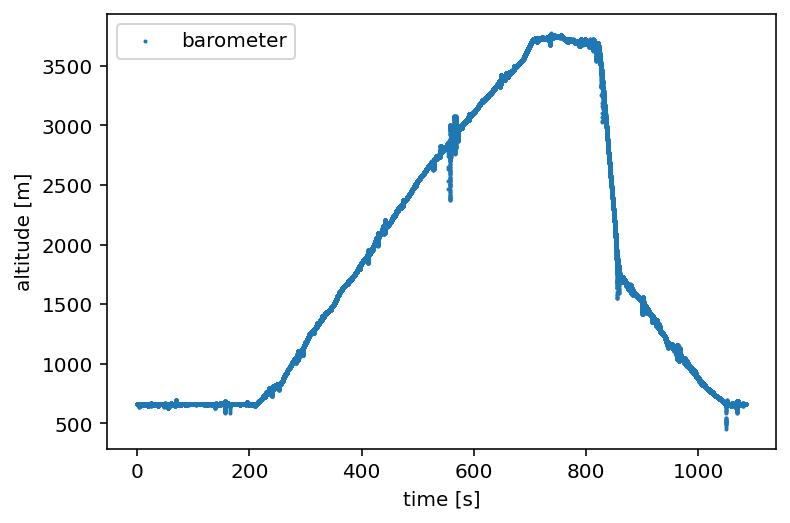

In [9]:
plt.scatter(x=df['seconds_elapsed'], y=df['altitude'], s=1,
            label='barometer')
plt.legend()
set_labels(y='altitude [m]')
plt.savefig('altitude-overview.png', dpi=300)

In [10]:
# Crop to the time of the jump.
df = df[df['seconds_elapsed'] >= 775]

In [11]:
df['altitude_median_1s'] = df['altitude'].rolling(ROWS_PER_S, center=True).median()
df['altitude_mean_1s'] = df['altitude'].rolling(ROWS_PER_S, center=True).mean()
df = df[df['altitude_median_1s'].notna()]

In [12]:
df['acc'] = np.sqrt(df['x'] ** 2 + df['y'] ** 2 + df['z'] ** 2)

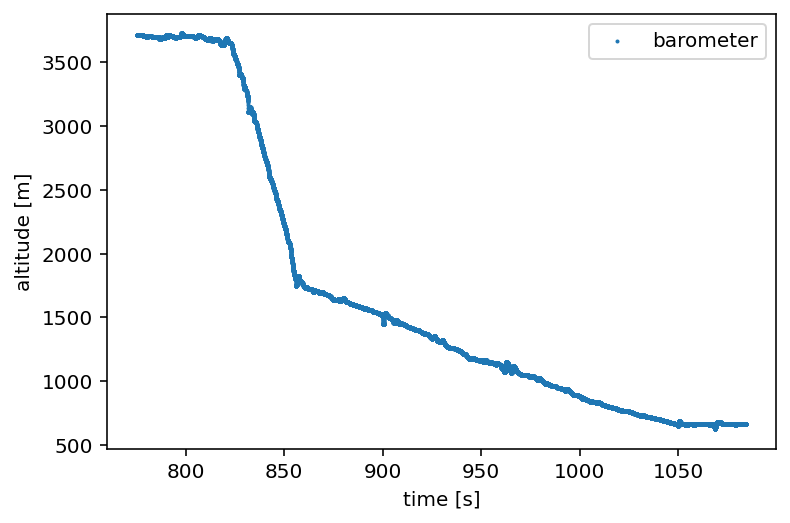

In [13]:
plt.scatter(x=df['seconds_elapsed'], y=df['altitude_median_1s'], s=1,
            label='barometer')
plt.legend()
set_labels(y='altitude [m]')
plt.savefig('altitude-zommed.png', dpi=300)

Timing of the **main events**, inferred from the altitude:

 * Jump out of the plane: around 09:01:59 (**t+821s**)
 * Parachute opens: between 09:02:31 and 09:02:35 (**t+855s to t+858s**)
 * Landing: around 09:05:46 (**t+1049**)

In [14]:
def time_select(start: int, duration: int) -> pd.DataFrame:
    return (df['seconds_elapsed'] >= start) & (df['seconds_elapsed'] <= start + duration)

### Velocity

Determining the velocity based on the barometer.

In [15]:
df['altitude_change_1s'] = np.abs(
    - df['altitude_median_1s'].shift(periods=-ROWS_PER_S // 2)
    + df['altitude_median_1s'].shift(periods=ROWS_PER_S // 2))

df['altitude_change_1s_mean_5s'] = df['altitude_change_1s'].rolling(ROWS_PER_S * 5, center=True).mean()

df['velocity_kmh_mean_5s'] = df['altitude_change_1s_mean_5s'] * 3.6

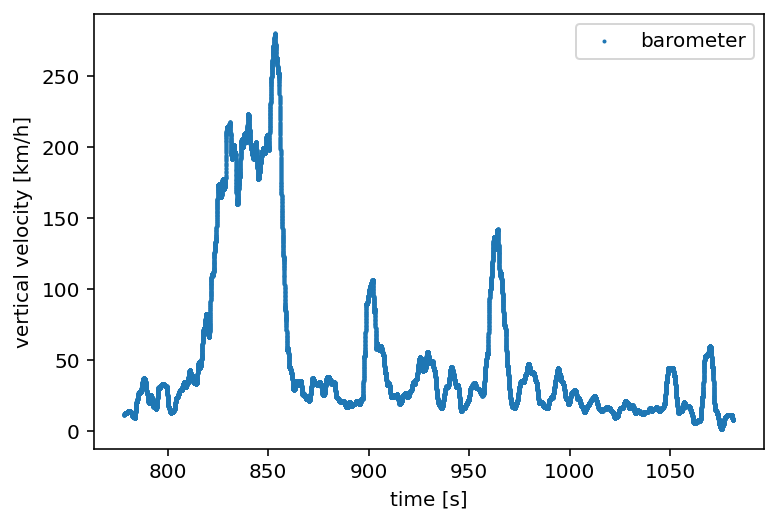

In [16]:
plt.scatter(x=df['seconds_elapsed'], y=df['velocity_kmh_mean_5s'], s=1,
            label='barometer')
plt.legend()
set_labels(y='vertical velocity [km/h]')
plt.savefig('velocity.png', dpi=300)

Velocity during the parachute deployment.

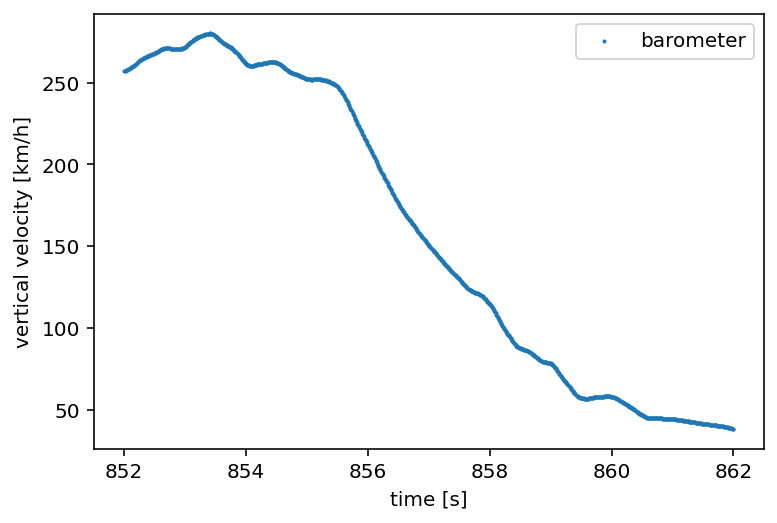

In [17]:
df_chute_deploy = df[time_select(852, 10)]
plt.scatter(x=df_chute_deploy['seconds_elapsed'],
            y=df_chute_deploy['velocity_kmh_mean_5s'], s=1,
            label='barometer')
plt.legend()
set_labels(y='vertical velocity [km/h]')
plt.savefig('velocity-chute-deployment.png', dpi=300)

Acceleration computation based on the change in velocity.

In [18]:
# Change in velocity over one second.
df['acc_from_velocity'] = np.abs(
    1 / 3.6 * (  # Conversion from km/h to m/s.
    df['velocity_kmh_mean_5s'].shift(periods=ROWS_PER_S // 2)
    - df['velocity_kmh_mean_5s'].shift(periods=-ROWS_PER_S // 2)))

### Acceleration

In [19]:
df['acc_mean_1s'] = df['acc'].rolling(ROWS_PER_S // 10, center=True).mean()
df = df[df['acc_mean_1s'].notna()]

#### Free Fall Phase

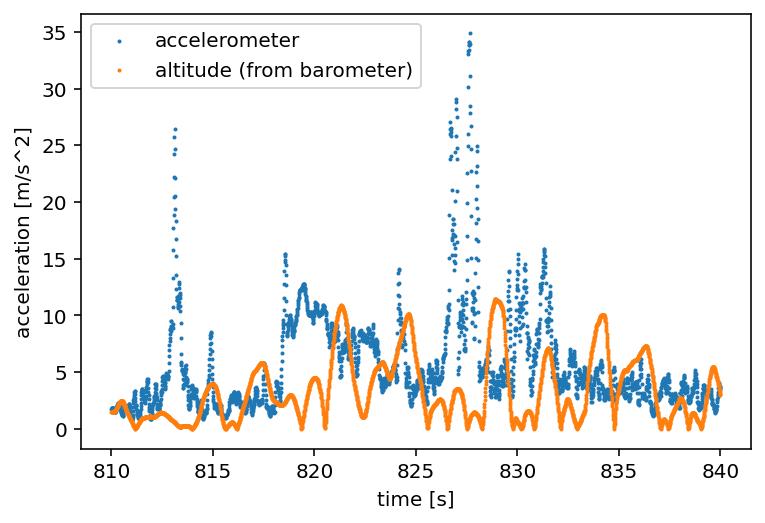

In [20]:
df_free_fall = df[time_select(810, 30)]
plt.scatter(x=df_free_fall['seconds_elapsed'],
            y=df_free_fall['acc_mean_1s'], s=1,
            label='accelerometer')
plt.scatter(x=df_free_fall['seconds_elapsed'],
            y=df_free_fall['acc_from_velocity'], s=1,
            label='altitude (from barometer)')
plt.legend(loc='upper left')
set_labels(y='acceleration [m/s^2]')
plt.savefig('acceleration-free-fall.png', dpi=300)

#### Parachute Deployment

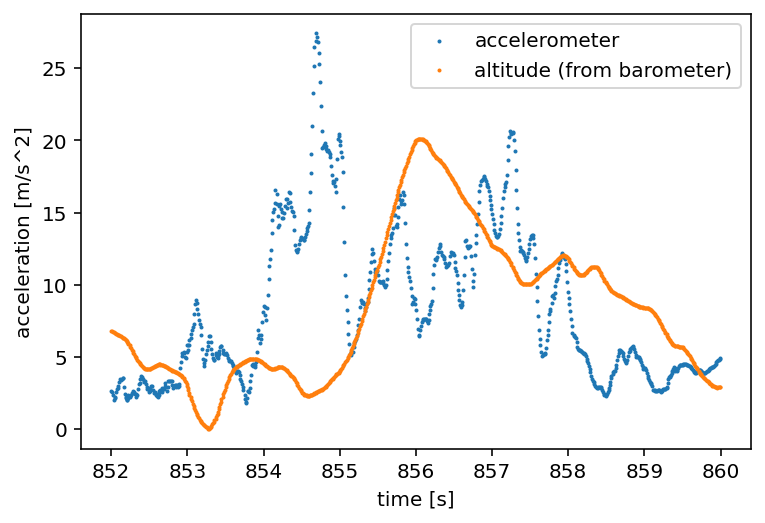

In [21]:
df_chute_deploy = df[time_select(852, 8)]
plt.scatter(x=df_chute_deploy['seconds_elapsed'],
            y=df_chute_deploy['acc_mean_1s'], s=1,
            label='accelerometer')
plt.scatter(x=df_chute_deploy['seconds_elapsed'],
            y=df_chute_deploy['acc_from_velocity'], s=1,
            label='altitude (from barometer)')
plt.legend(loc='upper right')
set_labels(y='acceleration [m/s^2]')
plt.savefig('acceleration-chute-deployment.png', dpi=300)